# Project: Wrangle and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather Data</a></li>
<li><a href="#assess">Assess Data</a></li>
<li><a href="#clean">Clean Data</a></li>
<li><a href="#analyze">Storing, Analyzing, and Visualizing Data</a></li>    
</ul>

<a id='intro'></a>
## Introduction

This project will gather, assess, clean, and analyze Twitter data from the tweet archive of user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.



In [414]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import os
import tweepy
import timeit
import json
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from PIL import ImageFilter
import seaborn as sns

<a id='gather'></a>
## Gather Data

### 1. Data provided by WeRateDogs 

In [415]:
# Read in provided archive data and display head
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Neural network data from Udacity server

In [416]:
# Download image predictions from Udacity server and view head
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
open('image_predictions.tsv', 'wb').write(response.content)
df_image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
df_image_predictions.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Additional Twitter API data from WeRateDogs

In [11]:
# Create access variables
consumer_key = 'Private'
consumer_secret = 'Private'
access_token = 'Private'
access_secret = 'Private'

In [12]:
# Create API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [13]:
# Create error counter
errors_count = 0

# Print start message for timing completion purposes
start = timeit.timeit()
print("Executing gathering operation")

# Create variable of tweet IDs to match to twitter archive dataframe 
tweet_ids = df_twitter_archive.tweet_id.values

# Gather data and write to JSON file
with open('tweet_json.txt', 'w') as output:
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, output)
            output.write('\n')
        except tweepy.TweepError:
            print("Error with Tweet ID:", tweet_id)            
            errors_count += 1
# Show end message to note completion of data gathering operation
end = timeit.timeit()
print("The operation took ", end - start, " seconds to complete.")
print("There were errors with ", errors_count, " tweets.")

Executing gathering operation
Error with Tweet ID: 888202515573088257
Error with Tweet ID: 873697596434513921
Error with Tweet ID: 872668790621863937
Error with Tweet ID: 872261713294495745
Error with Tweet ID: 869988702071779329
Error with Tweet ID: 866816280283807744
Error with Tweet ID: 861769973181624320
Error with Tweet ID: 856602993587888130
Error with Tweet ID: 851953902622658560
Error with Tweet ID: 845459076796616705
Error with Tweet ID: 844704788403113984
Error with Tweet ID: 842892208864923648
Error with Tweet ID: 837366284874571778
Error with Tweet ID: 837012587749474308
Error with Tweet ID: 829374341691346946
Error with Tweet ID: 827228250799742977
Error with Tweet ID: 812747805718642688
Error with Tweet ID: 802247111496568832
Error with Tweet ID: 779123168116150273
Error with Tweet ID: 775096608509886464
Error with Tweet ID: 771004394259247104
Error with Tweet ID: 770743923962707968
Error with Tweet ID: 759566828574212096
Rate limit reached. Sleeping for: 729
Error with T

In [417]:
# Create a list for the required tweet ID, retweet count, and favorite count from JSON file
tweets_data =[]

with open('tweet_json.txt') as json_file:
    for line in json_file:
    
        tweets_dictionary = {}
        tweets_json = json.loads(line)
        
        try:            
            tweets_dictionary['tweet_id'] = tweets_json['id']
        except:
            tweets_dictionary['tweet_id'] = 'na'

        tweets_dictionary['retweet_count'] = tweets_json['retweet_count']
        tweets_dictionary['favorite_count'] = tweets_json['favorite_count']
        tweets_dictionary['timestamp'] = tweets_json['created_at'] 
        
        tweets_data.append(tweets_dictionary)

In [418]:
# Convert JSON data to dataframe and view head
df_additional_data = pd.DataFrame(tweets_data)
df_additional_data.head()

,favorite_count,retweet_count,timestamp,tweet_id
0,35508,7507,Tue Aug 01 16:23:56 +0000 2017,892420643555336193
1,30742,5570,Tue Aug 01 00:17:27 +0000 2017,892177421306343426
2,23102,3690,Mon Jul 31 00:18:03 +0000 2017,891815181378084864
3,38790,7683,Sun Jul 30 15:58:51 +0000 2017,891689557279858688
4,37075,8292,Sat Jul 29 16:00:24 +0000 2017,891327558926688256


<a id='assess'></a>
## Assess Data

### First I will look for any issues with the data provided by WeRateDogs

In [419]:
# Visual assessment
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [420]:
# View a sample
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
877,760893934457552897,NaN,NaN,2016-08-03 17:43:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wishes. He has the day off. Daily stru...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760893934...,11,10,Wishes,doggo,None,None,None
1731,679844490799091713,NaN,NaN,2015-12-24 02:02:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Willie. He's floating away and needs y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679844490...,10,10,Willie,None,None,None,None
1325,706166467411222528,NaN,NaN,2016-03-05 17:16:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dexter. He's a shy pup. Doesn't bark m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706166467...,7,10,Dexter,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
61,880221127280381952,NaN,NaN,2017-06-29 00:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jesse. He's a Fetty Woof. His tongue ejec...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/880221127...,12,10,Jesse,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
1342,704819833553219584,NaN,NaN,2016-03-02 00:05:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chesterson. He's a Bolivian Scoop Dog....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704819833...,7,10,Chesterson,None,None,None,None
777,776088319444877312,NaN,NaN,2016-09-14 16:00:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't tap the screen to make the hearts appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776088319...,10,10,None,None,None,None,None
1741,679475951516934144,NaN,NaN,2015-12-23 01:37:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Evy. She doesn't want to be a Koala. 9...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679475951...,9,10,Evy,None,None,None,None
1335,705239209544720384,NaN,NaN,2016-03-03 03:51:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jimothy. He lost his body during the t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/705239209...,11,10,Jimothy,None,None,None,None


I noticed a tidiness issue with the last 4 columns which show dog types, might need to consolidate into one "type" column.  Also, I saw words like "a" and "None" listed in the name column, I think for the purposes of analysis null values may be better.

In [421]:
# Display info to look for null data
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

We were told to ignore retweets, so those rows need to be dropped.  Missing some expanded URLs.

In [422]:
# Look at value counts for dog types
doggo = df_twitter_archive.doggo.value_counts()
floofer = df_twitter_archive.floofer.value_counts()
pupper = df_twitter_archive.pupper.value_counts()
puppo = df_twitter_archive.puppo.value_counts()

print(doggo)
print(floofer)
print(pupper)
print(puppo)

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


Looking more into the dog type values to see if those columns can be consolidated. Will check to see if any have multiple columns with types listed.

In [423]:
# Select all "pupper" rows, then look to see if any also have "doggo" listed
multi_pupper = df_twitter_archive[df_twitter_archive['pupper'] == 'pupper']
multi_pupper['doggo'].value_counts()

None     245
doggo     12
Name: doggo, dtype: int64

Since there are rows with both pupper and doggo values, the columns cannot be consolidates.  Instead I feel they should be changed to 0 for "none" and 1 for a value.

In [424]:
# Look at numerator column values
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [425]:
# Look at denominator column values
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

The denominator of "10" seems to be the standard, so all other rows should be dropped as they don't fall in the same scale.

In [426]:
#Check for duplicated tweet IDs
df_twitter_archive.tweet_id.duplicated().sum()             

0

There are no duplicated tweet IDs, but the retweet/replies can be considered duplicate entries since the same information (ratings, etc.) are used.

In [427]:
# Check name column for invalid names such as "None" and "a"
df_twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Tucker        10
Lola          10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Daisy          7
an             7
Toby           7
Bailey         7
Buddy          7
Milo           6
Bella          6
Leo            6
Rusty          6
Scout          6
Jack           6
Jax            6
Dave           6
Stanley        6
Oscar          6
Koda           6
Finn           5
            ... 
Amélie         1
Stefan         1
Randall        1
Pupcasso       1
Franq          1
Dudley         1
Crimson        1
Socks          1
Bradlay        1
Snicku         1
Lizzie         1
Peanut         1
Geno           1
Kollin         1
Karl           1
Nico           1
Acro           1
Tycho          1
Fabio          1
Divine         1
Orion          1
Mutt           1
Claude         1
Hermione       1
Batdog         1
Chubbs         1
Tassy          1
Beya          

"A", "an", and "None" should be replaced with null values

### Cleaning Assessment for WeRateDogs Archive Data
#### Quality
* Change values of dog type columns to true or false boolean types
* Drop rows where the denominator does not equal 10
* Change datatype for timestamp
* Names of "a", "an", and "None" should be replaced with null values

#### Tidiness
* Retweets (181 rows) should not be included.  Those entries represent a duplication of data.
* Replies (78 rows) should not be included.  Those entries represent a duplication of data.

### Next I will assess the image predictions 

In [428]:
# Visual assessment
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


The data looks tidy.  I will change the columns for the predictions from "p" to "prediction" so that they are more meaningful. Also, some dog breed predictions begin lowercase and most are upper, should be uniform

In [429]:
# Look at info for datatypes and null values
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The data types look appropriate and there do not appear to be any null values. I only plan to use the data from the first prediction, so all other prediction columns associated with the second and third predictions can be dropped

### Cleaning Assessment for Image Prediction Data
#### Quality
* Change the column names for predictions columns to something more meaningful
* Uniform case on breed prediction columns
* Delete unused columns

### Finally I will assess the Twitter API download data

In [430]:
# Visual assessment
df_additional_data

,favorite_count,retweet_count,timestamp,tweet_id
0,35508,7507,Tue Aug 01 16:23:56 +0000 2017,892420643555336193
1,30742,5570,Tue Aug 01 00:17:27 +0000 2017,892177421306343426
2,23102,3690,Mon Jul 31 00:18:03 +0000 2017,891815181378084864
3,38790,7683,Sun Jul 30 15:58:51 +0000 2017,891689557279858688
4,37075,8292,Sat Jul 29 16:00:24 +0000 2017,891327558926688256
5,18692,2777,Sat Jul 29 00:08:17 +0000 2017,891087950875897856
6,10865,1801,Fri Jul 28 16:27:12 +0000 2017,890971913173991426
7,59856,16805,Fri Jul 28 00:22:40 +0000 2017,890729181411237888
8,25705,3827,Thu Jul 27 16:25:51 +0000 2017,890609185150312448
9,29361,6527,Wed Jul 26 15:59:51 +0000 2017,890240255349198849


In [431]:
# View datatypes and null values
df_additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
timestamp         2331 non-null object
tweet_id          2331 non-null int64
dtypes: int64(3), object(1)
memory usage: 72.9+ KB


The timestamp is in string format, would be better as datetime.

In [432]:
#Check for dumplicate IDs
df_additional_data.tweet_id.duplicated().sum()

0

### Cleaning Assessment for API Download
#### Quality
* timestamp in string format

## Cleaning Assessment Summary

### WeRateDogs Archive Data
#### Quality
* Change values of dog type columns to true or false boolean types
* Drop rows where the denominator does not equal 10
* Change datatype for timestamp
* Names of "a", "an", and "None" should be replaced with null values

#### Tidiness
* Retweets (181 rows) should not be included.  Those entries represent a duplication of data.
* Replies (78 rows) should not be included.  Those entries represent a duplication of data.

### Image Prediction Data
#### Quality
* Change the column names for predictions columns to something more meaningful
* Uniform case on breed prediction columns
* Delete unused columns

### API Download
#### Quality
* timestamp in string format

#### Tidiness
* Finally, after the above issues are addressed, data should be merged into a single dataframe for analysis since it is related by tweet_id

<a id='clean'></a>
## Clean Data

In [433]:
# Copy all tables to new clean tables
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_additional_data_clean = df_additional_data.copy()

### 1. Clean WeRateDogs Archive Data
#### Quality
* Change values of dog type columns to true or false boolean types
* Drop rows where the denominator does not equal 10
* Change datatype for timestamp
* Names of "a", "an", and "None" should be replaced with null values

#### Tidiness
* Retweets (181 rows) should not be included.  Those entries represent a duplication of data.
* Replies (78 rows) should not be included.  Those entries represent a duplication of data.

* **Change values of dog type columns to true or false**

##### Define: Use .replace function to change the value of  the four dog type columns to boolean true|false values

##### Code: 

In [434]:
# Change values in columns using .replace
df_twitter_archive_clean.doggo.replace(('doggo', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.floofer.replace(('floofer', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.pupper.replace(('pupper', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.puppo.replace(('puppo', 'None'), (True, False), inplace=True)

##### Test: 

In [435]:
doggo = df_twitter_archive_clean.doggo.value_counts()
floofer = df_twitter_archive_clean.floofer.value_counts()
pupper = df_twitter_archive_clean.pupper.value_counts()
puppo = df_twitter_archive_clean.puppo.value_counts()

print(doggo)
print(floofer)
print(pupper)
print(puppo)

False    2259
True       97
Name: doggo, dtype: int64
False    2346
True       10
Name: floofer, dtype: int64
False    2099
True      257
Name: pupper, dtype: int64
False    2326
True       30
Name: puppo, dtype: int64


In [436]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null bool
floofer                       2356 non-null bool
pupper                        2356 non-null bool
puppo                         2356 non-null bool
dtypes: bool(4), float64(4), int64(3), o

* **Drop rows where the denominator does not equal 10**

##### Define:  Use .drop method to remove rows where the denominator does not equal 10 for consistency

##### Code: 

In [437]:
# Drop rows where denominator does not equal 10
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10].index, inplace = True)

##### Test: 

In [438]:
# Check to see if their are any values besides 10 for the denominator
df_twitter_archive_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

* **Change datatype for timestamp**

##### Define: Convert string datatype for timestamp column to datetime using to_datetime

##### Code: 

In [439]:
# Convert timestamp column to datetime
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'])

##### Test: 

In [440]:
# Check datetype for timestamp
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2333 non-null int64
in_reply_to_status_id         73 non-null float64
in_reply_to_user_id           73 non-null float64
timestamp                     2333 non-null datetime64[ns]
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null object
expanded_urls                 2278 non-null object
rating_numerator              2333 non-null int64
rating_denominator            2333 non-null int64
name                          2333 non-null object
doggo                         2333 non-null bool
floofer                       2333 non-null bool
pupper                        2333 non-null bool
puppo                         2333 non-null bool
dtypes: bool(4), datetime64[ns](

In [441]:
# Look at format for timestamp column
df_twitter_archive_clean['timestamp'].head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

* **Names of "a", "an", and "None" should be replaced with null values.**

##### Define: Use . replace method to replace  "a", "an", and "None" with null data

##### Code:

In [442]:
# Use .replace on name column to eliminate invalid names
df_twitter_archive_clean.name.replace(('a', 'an', 'None'), (''), inplace=True)

##### Test:

In [443]:
# Ensure instances of invalid names are eliminated
df_twitter_archive_clean.name.value_counts()

            788
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
the           8
Sadie         8
Buddy         7
Toby          7
Daisy         7
Bailey        7
Jack          6
Oscar         6
Dave          6
Koda          6
Bella         6
Jax           6
Stanley       6
Rusty         6
Leo           6
Scout         6
Milo          6
Alfie         5
very          5
George        5
           ... 
Hero          1
Mya           1
Amélie        1
Stefan        1
Randall       1
Crimson       1
Coopson       1
Strider       1
Acro          1
Staniel       1
Socks         1
Snicku        1
Lizzie        1
Peanut        1
Geno          1
Kollin        1
Karl          1
Nico          1
Tycho         1
Beya          1
Bradlay       1
Fabio         1
Orion         1
Mutt          1
Claude        1
Hermione      1
Batdog        1
Chubbs        1
Tassy         1
Gert          1
Name: name, Length: 952,

* **Retweets (181 rows) should not be included. Those entries represent a duplication of data.**

##### Define:  Since null values are used when messages are retweeted, drop all rows where the retweeted status ID is not a null using .drop method

##### Code: 

In [444]:
# Drop rows where retweeted_status_id is not a null value
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.notnull()].index, inplace = True)

##### Test: 

In [445]:
# Check to see if there are any values in retweeted status ID which are not null
df_twitter_archive_clean.retweeted_status_id.notnull().sum()

0

* **Replies (78 rows) should not be included. Those entries represent a duplication of data.**

##### Define: Use the same method as above to remove all rows where the in_reply_to_status_id is null

##### Code: 

In [446]:
# Drop rows where in_reply_to_status_id is not a null value
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.in_reply_to_status_id.notnull()].index, inplace = True)

##### Test: 

In [447]:
# Look for non-null values
df_twitter_archive_clean.in_reply_to_status_id.notnull().sum()

0

### 2. Clean Image Data

#### Quality
* Change the column names for predictions columns to something more meaningful
* Uniform case on breed prediction columns
* Delete unused columns

* **Change the column names for predictions columns to something more meaningful**

##### Define: Create an array mapping the old names to the new names, then use the.rename function to rename the columns using the array

##### Code: 

In [448]:
# Rename prediction columns to something more meaningful
prediction_columns = {'p1':'prediction1', 'p1_conf':'prediction1_confidence', 'p1_dog':'prediction1_dog', 
                      'p2':'prediction2', 'p2_conf':'prediction2_confidence', 'p2_dog':'prediction2_dog',
                      'p3':'prediction3', 'p3_conf':'prediction3_confidence', 'p3_dog':'prediction3_dog',}

df_image_predictions_clean.rename(columns= prediction_columns, inplace=True)

##### Test: 

In [449]:
# View column names by looking at info
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
img_num                   2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* **Uniform case on breed prediction columns**

##### Define: Use str.capitalize method to capitalize the name in the prediction column. (Note: Will only capitalize prediction 1 since the others are being dropped in the next step)

##### Code: 

In [450]:
# Use str.capitalize on prediction1 column
df_image_predictions_clean['prediction1'] = df_image_predictions_clean['prediction1'].str.capitalize() 

##### Test: 

In [451]:
# Ensure all values are capitalized
df_image_predictions_clean.prediction1.value_counts()

Golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
Pug                           57
Chow                          44
Samoyed                       43
Toy_poodle                    39
Pomeranian                    38
Malamute                      30
Cocker_spaniel                30
French_bulldog                26
Miniature_pinscher            23
Chesapeake_bay_retriever      23
Seat_belt                     22
Staffordshire_bullterrier     20
Siberian_husky                20
German_shepherd               20
Cardigan                      19
Web_site                      19
Maltese_dog                   18
Beagle                        18
Eskimo_dog                    18
Shetland_sheepdog             18
Teddy                         18
Rottweiler                    17
Shih-tzu                      17
Lakeland_terrier              17
Italian_greyhound             16
Kuvasz                        16
          

* **Delete unused columns**

##### Define:  Delete unused columns using .drop method

##### Code: 

In [452]:
# Drop unused columns
df_image_predictions_clean.drop(['prediction2', 'prediction2_confidence', 'prediction2_dog', 'prediction3', 'prediction3_confidence', 'prediction3_dog'], axis = 1, inplace = True) 

##### Test: 

In [453]:
# Look at info to ensure only desired columns remain
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
img_num                   2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 83.2+ KB


### 3. Clean API Download Data

#### Quality
* timestamp in string format

##### Define: Convert string datatype for timestamp column to datetime using to_datetime

##### Code: 


In [454]:
# Convert timestamp column to datetime
df_additional_data_clean['timestamp'] = pd.to_datetime(df_additional_data_clean['timestamp'])

##### Test: 

In [455]:
# Check datetype for timestamp
df_additional_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
timestamp         2331 non-null datetime64[ns]
tweet_id          2331 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 72.9 KB


In [456]:
# Look at format for timestamp column
df_additional_data_clean['timestamp'].head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

### 4. Merge all dataframes into a single dataframe

In [457]:
# First merge the archive and image prediction dataframes
df_archive_image = pd.merge(df_twitter_archive_clean, df_image_predictions_clean, on = ['tweet_id'], how = 'left')
df_archive_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 22 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null bool
floofer                       2080 non-null bool
pupper                        2080 non-null bool
puppo                         2080 non-null bool
jpg_url                       1954 non-n

In [458]:
# Next merge the API dataframe into the already merged data
df_twitter_data_complete = pd.merge(df_archive_image, df_additional_data_clean, on = ['tweet_id'], how = 'left')

In [459]:
# View info for merged dataframe to check that all rows combined properly
df_twitter_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 25 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp_x                   2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null bool
floofer                       2080 non-null bool
pupper                        2080 non-null bool
puppo                         2080 non-null bool
jpg_url                       1954 non-n

<a id='analyze'></a>
## Storing, Analyzing, and Visualizing Data

### Storing Data

In [460]:
# Save the API data to CSV file
df_additional_data_clean.to_csv('df_additional_data_clean.csv', index=False, encoding = 'utf-8')

In [461]:
# Save the merged and clean DataFrame to a CSV file
df_twitter_data_complete.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

### Analysis and Insights

#### Insight 1: What is the most common dog type?

In [462]:
# Calculate total of each type
doggo = df_twitter_data_complete.doggo.sum()
floofer = df_twitter_data_complete.floofer.sum()
pupper = df_twitter_data_complete.pupper.sum()
puppo = df_twitter_data_complete.puppo.sum()

print('Doggo', doggo)
print('Floofer', floofer)
print('Pupper', pupper)
print('Puppo', puppo)

Doggo 83
Floofer 10
Pupper 230
Puppo 24


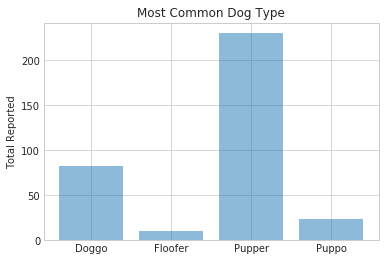

In [463]:
# Plot popularity on bar graph
dog_types = ('Doggo', 'Floofer', 'Pupper', 'Puppo')
y_pos = np.arange(len(dog_types))
totals = [doggo,floofer,pupper,puppo]

plt.bar(y_pos, totals, align='center', alpha=0.5)
plt.xticks(y_pos, dog_types)
plt.ylabel('Total Reported')
plt.title('Most Common Dog Type')

plt.show()

**"Pupper" is the most reported dog category type**

#### Insight 2: What are the most popular dog names?

In [464]:
# Create a dataframe that does not inclue "None" as a name
df_without_none = df_twitter_data_complete[df_twitter_data_complete.name != '']

# Isolate top 30 names by frequency
names_summary = df_without_none.groupby('name')['tweet_id'].count()
top_names = names_summary.nlargest(30)

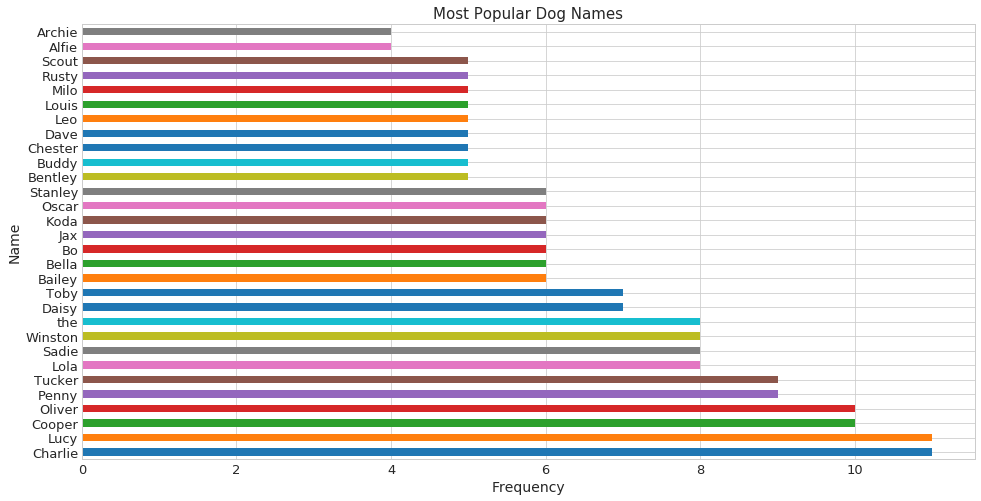

In [465]:
# Plot the most popular dog names
top_names.plot(kind='barh',figsize=(16,8),fontsize=13)
plt.title("Most Popular Dog Names",fontsize=15)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Name',fontsize=14)
sns.set_style("whitegrid")

**The  top names include: Charlie, Lucy, Cooper, Oliver, and Lola.  I find it interesting that most are names commonly used for humans as well.**

#### Insight 3: Is there a relationship between favorites and retweets?

Text(0.5,1,'Retweets and Favorites Scatter plot')

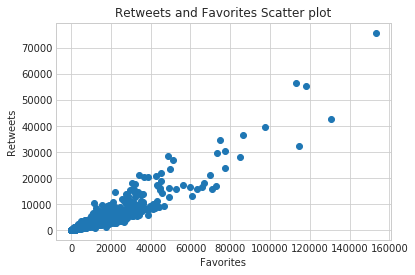

In [466]:
# Display scatterplot for retweets and likes
plt.scatter(df_twitter_data_complete['favorite_count'], df_twitter_data_complete['retweet_count'])
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and Favorites Scatter plot')

**The plot appears to trend upward in a linear fashion, suggesting that favorites tend to be retweeted**

#### Insight 4: What is the most predicted breed of dog?

In [473]:
# Subset breed information where prediction1_dog is true
df_breed_true = df_twitter_data_complete[df_twitter_data_complete['prediction1_dog'] == True]

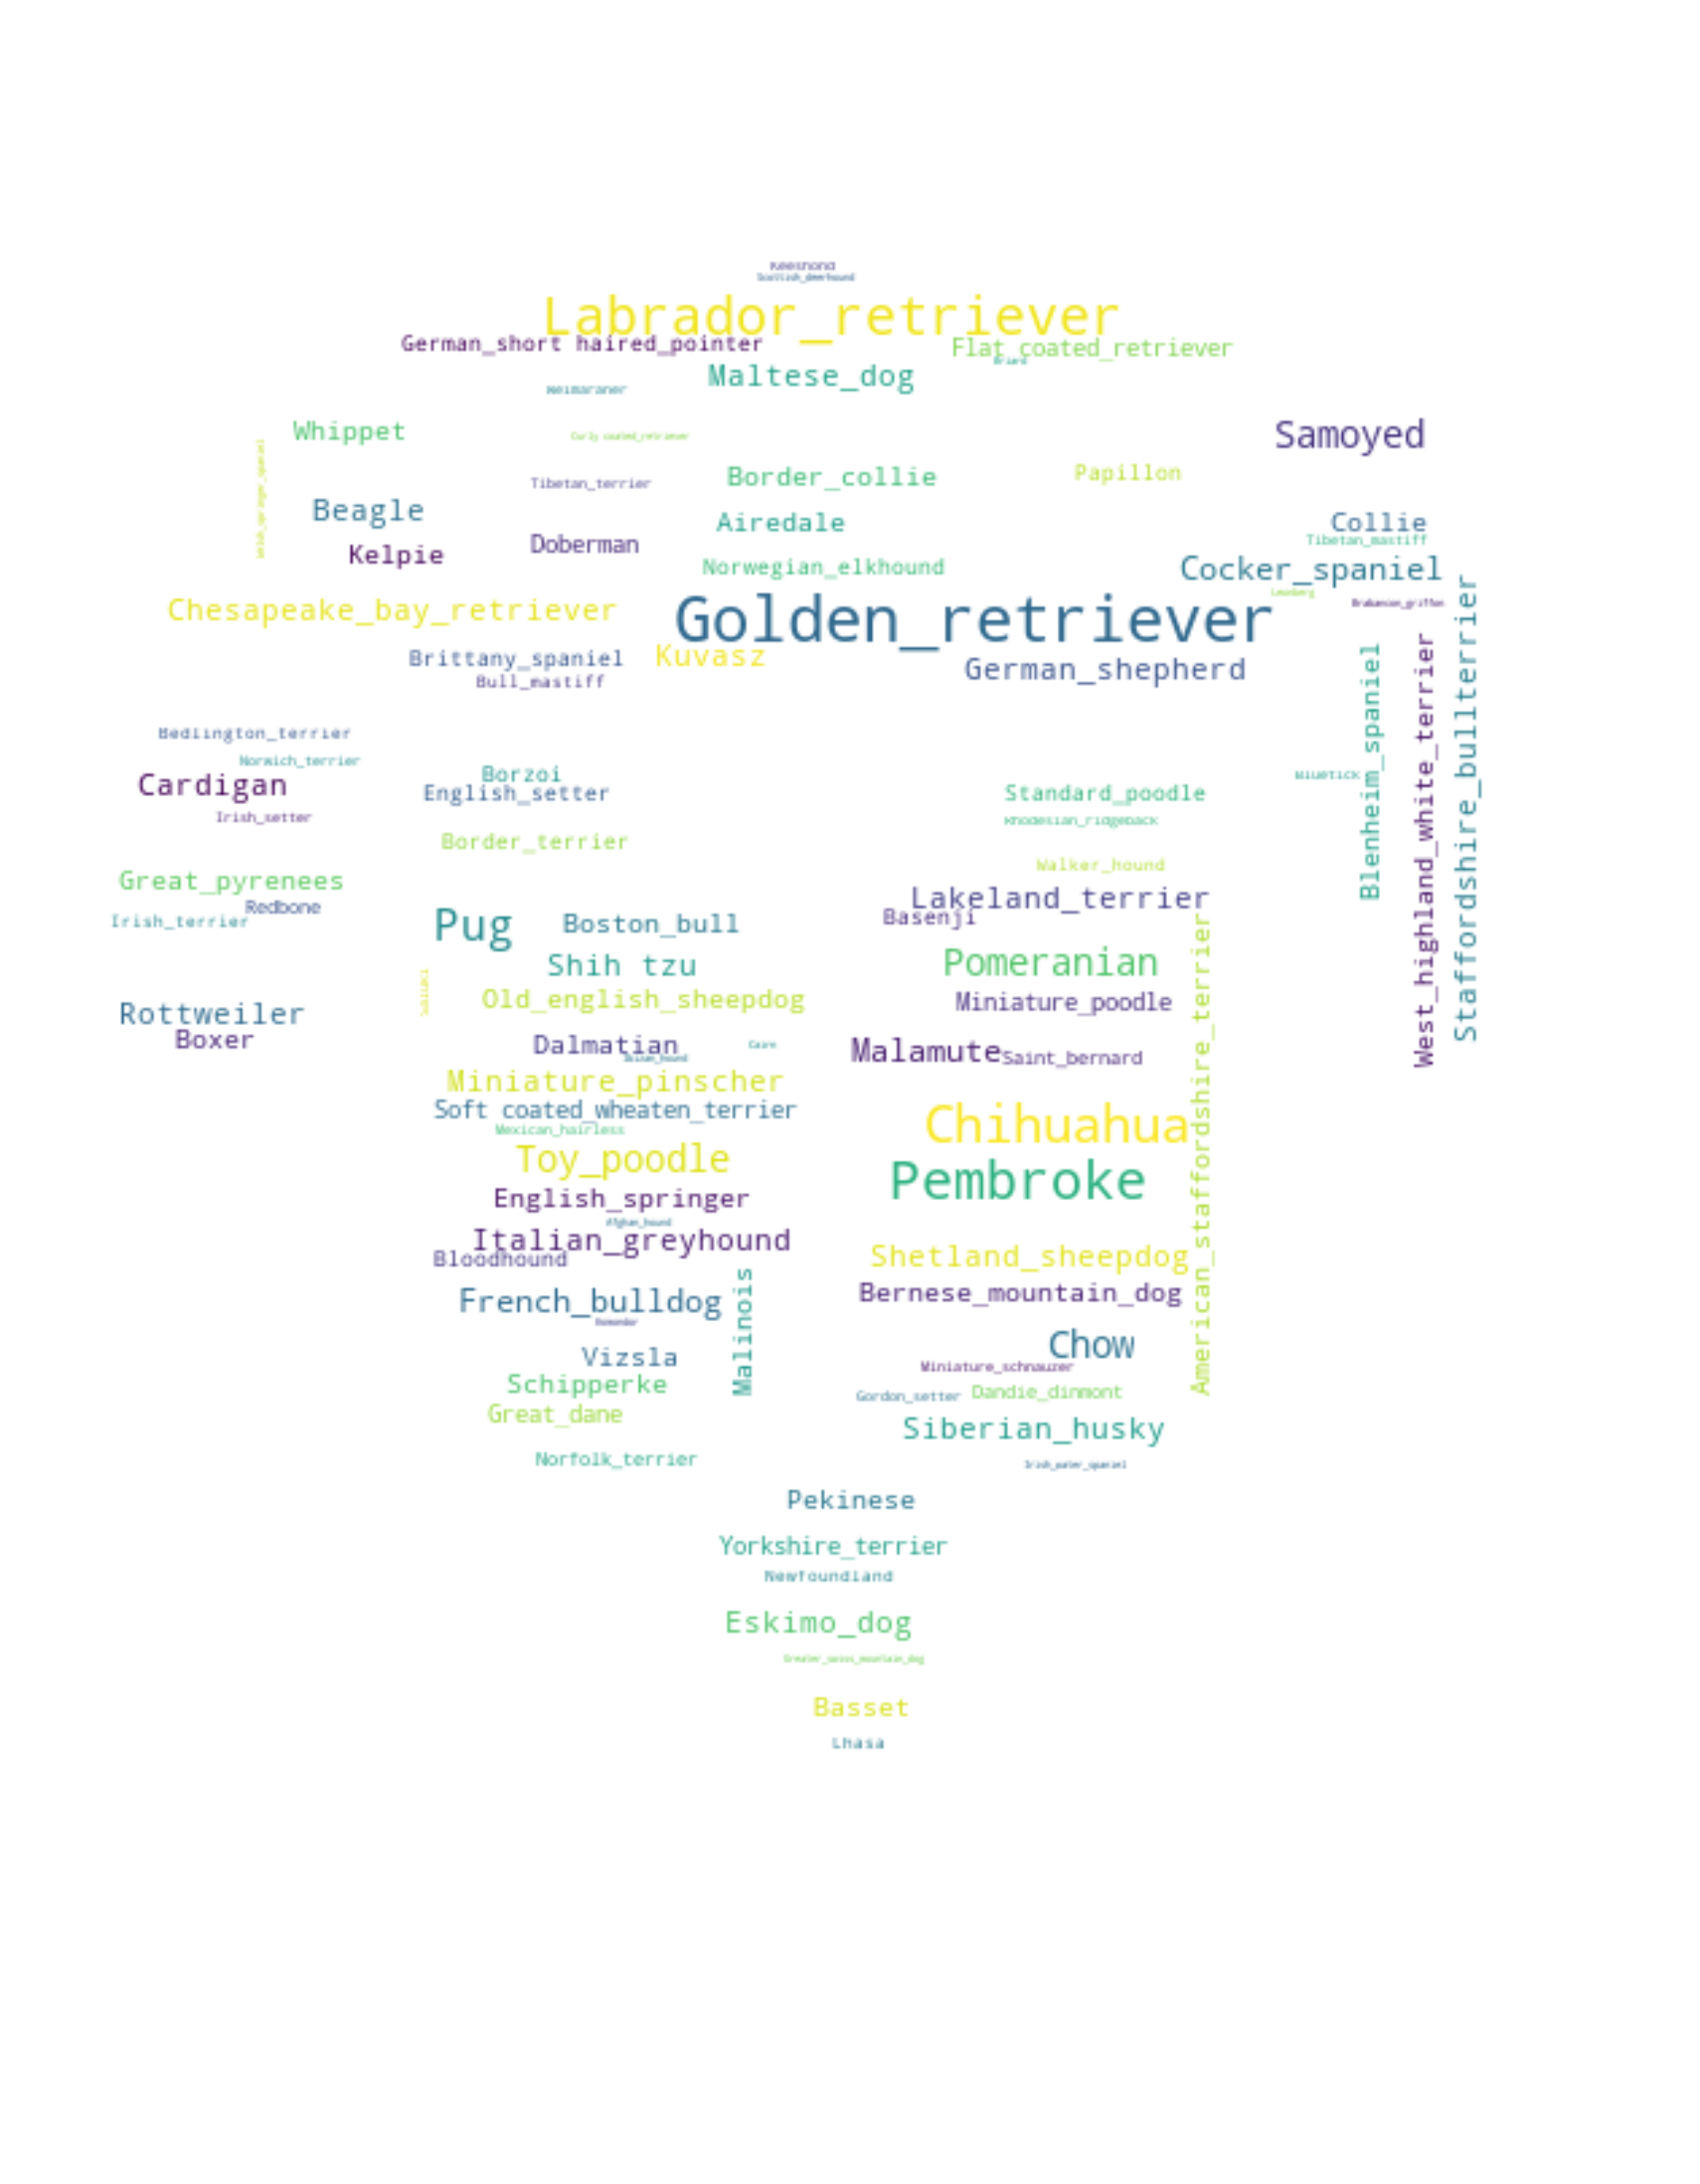

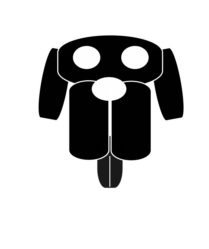

In [472]:
# Concatenate all breeds
breed = df_breed_true.prediction1.str.cat(others=None, sep=' ')

# Read the mask image
# ref: https://openclipart.org/detail/70609/dog-face
dog_mask = np.array(Image.open('dog_face.jpg'))

# Words to exclude from word cloud
stopwords = set(STOPWORDS)
words = ['https', 'enough', 'damn', 'nothing', 'much']
for word in words:
    stopwords.add(word)


# Instantiate word cloud object
wc = WordCloud(background_color='white', max_words=200, mask=dog_mask, stopwords=stopwords,
              width=480, height=640)
# Generate word cloud
wc.generate(breed)
# Show word cloud
plt.figure( figsize=(30,150) )
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.figure()
plt.imshow(dog_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

**It looks like golden retriever, labrador retriever, pembroke, and chihuahua are the most predicted dog breeds**